# Comparing the run results with the ideal QITE runs
$\newcommand{\bra}[1]{\langle{#1}|}$
$\newcommand{\ket}[1]{|{#1}\rangle}$
$\newcommand{\braket}[2]{\langle{#1}|{#2}\rangle}$
## Using the log files to determine the state evolution
In some runs of the program, I found that after reaching a mean energy close to the first excited state of the Hamiltonian, the energy of time evolved state jumps up and does not converge to ground state energy afterwards. The only difference between runs that properly converge and those that do not are the measurement statistics obtained in the run. This leads me to believe that these runs happen to have measurements that evolve the state into one that has very small component of the ground state in the superposition. Such a state will not converge to the ground state in the short term.

I've added logging functionality to the qite program so that at the end of the execution, it stores `[db, delta, N, nbits, hm_list, alist]` in `hm-alist.npy` (or other file name that's passed into `qite()`)

From the logged data, I will generate the circuit at each time step and evolve using a state vector simulator and plot the fidelity
$$ |\braket{\phi_{gs}}{\psi(\beta)}|^2 $$
for each time step in the run. For runs that did not converge to the gound state, we should expect the fidelity to converge towards zero when the energy reaches the first excited state.

If this is indeed the case, we can use this to identify signatures of bad runs and cull or correct them before wasting more computing resources.

Next I will calculate the theoretical measurement statistics for each time step and make a circuit based on that, and compare the evolution of the theoretical statistics with that of the simulation.

In [1]:
import numpy as np
from helper import *
from qite import propogate, update_alist, log_qite_run

from qiskit import QuantumCircuit, Aer

import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from qiskit.quantum_info import Statevector, state_fidelity
sv_sim = Aer.get_backend('statevector_simulator')

## The ideal QITE run

In [4]:
x = np.load('./qite_logs/shots=1000/run001.npy',allow_pickle=True)
db = x[0]
delta = x[1]
N = x[2]
nbits = x[3]
hm_list = x[4]
alist = x[5]

In [5]:
print(hm_list)

[[[7], [0.7071067811865476], [0, 1]], [[1, 3], [0.5, 0.5], [1]]]


In [6]:
def pauli_expectation(psi, p, qbits):
    '''
    returns the theoretical expectation <psi|P|psi> where P is the pauli string acting on qbits, indexed by p
    '''
    nbits = int(np.log2(len(psi.data)))
    pstring = int_to_base(p,4,len(qbits))
    qc = QuantumCircuit(nbits)
    for i in range(len(qbits)):
        if pstring[i] == 1:
            qc.x(qbits[i])
        elif pstring[i] == 2:
            qc.y(qbits[i])
        elif pstring[i] == 3:
            qc.z(qbits[i])
    
    phi = psi.evolve(qc)
#     print(psi.data)
#     print(phi.data)
#     print(np.vdot(psi.data, phi.data))
    
    return np.real(np.vdot(psi.data, phi.data))

def ideal_energy(alist, nbits, hm_list):
    Energy = 0
    qc = QuantumCircuit(nbits)
    propogate(qc, alist)
    init_sv = [0]*(2**nbits)
    init_sv[0] = 1
    psi = Statevector(init_sv).evolve(qc)
    for hm in hm_list:
        for j in range(len(hm[0])):
            Energy += hm[1][j] * pauli_expectation(psi, hm[0][j], hm[2])
    return Energy

In [7]:
def ideal_tomography(alist, qbits, nbits):
    nactive = len(qbits)
    nops=  4**nactive
    
    sigma_expectation = np.zeros(nops,dtype=float)
    sigma_expectation[0] = 1.0
    
    qc = QuantumCircuit(nbits)
    propogate(qc,alist)
    init_sv = [0]*(2**nbits)
    init_sv[0] = 1
    psi = Statevector(init_sv).evolve(qc)
    
    for i in range(1,nops):
        sigma_expectation[i] = pauli_expectation(psi, i, qbits)
    return sigma_expectation, psi

def ideal_qite_step(alist, db, delta, nbits, hm_list):
    for hm in hm_list:
        # get the ideal state tomography
        sigma_expectation, psi = ideal_tomography(alist, hm[2], nbits)
        norm = update_alist(sigma_expectation, alist, db, delta, hm)
    return alist, psi

def ideal_qite(db,delta,N,nbits,hm_list,details=False,log=False,log_file='ideal-qite'):
    E = np.zeros(N+1,dtype=complex)
    times = np.zeros(N+1,dtype=float)
    
    states = []
    states.append(Statevector.from_label('0'*nbits))
    
    alist = []
    
    E[0] = ideal_energy(alist, nbits, hm_list)
    
    hmat = get_h_matrix(hm_list,nbits)
    
    start = 0
    end = 0
    if details:
        print('Starting QITE Loop')
    
    for i in range(1,N+1):
        if details:
            print('i={}'.format(i), end=' ', flush=True)
            start = time.time()
        
        alist,psi = ideal_qite_step(alist, db, delta, nbits, hm_list)
        E[i] = ideal_energy(alist, nbits, hm_list)
        states.append(psi)
        
        if details:
            end = time.time()
            duration = end-start
            times[i] = duration
            print('Execution time: {:.2f} seconds, <psi|H|psi> = {}'.format(duration, np.conj(psi.data) @ hmat @ psi.data.T ))
    
    if log:
        log_qite_run(db,delta,N,nbits,hm_list,alist,log_file)
    
    return E,times,states

In [8]:
E,times,states = ideal_qite(db,delta,N,nbits,hm_list,details=True,log=True,log_file='ideal-qite')

Starting QITE Loop
i=1 Execution time: 0.01 seconds, <psi|H|psi> = (0.4156032373073173+0j)
i=2 Execution time: 0.03 seconds, <psi|H|psi> = (0.26406913169507135+0j)
i=3 Execution time: 0.03 seconds, <psi|H|psi> = (0.10481370743036916+0j)
i=4 Execution time: 0.03 seconds, <psi|H|psi> = (-0.057539675957812064+0j)
i=5 Execution time: 0.03 seconds, <psi|H|psi> = (-0.2180019895491664+0j)
i=6 Execution time: 0.03 seconds, <psi|H|psi> = (-0.37181823210976206+0j)
i=7 Execution time: 0.03 seconds, <psi|H|psi> = (-0.5150084224626889+0j)
i=8 Execution time: 0.04 seconds, <psi|H|psi> = (-0.644726070173221+0j)
i=9 Execution time: 0.04 seconds, <psi|H|psi> = (-0.7593798849669541+0j)
i=10 Execution time: 0.04 seconds, <psi|H|psi> = (-0.8585416583637926+0j)
i=11 Execution time: 0.04 seconds, <psi|H|psi> = (-0.9427136424478803+0j)
i=12 Execution time: 0.04 seconds, <psi|H|psi> = (-1.0130405129812217+0j)
i=13 Execution time: 0.04 seconds, <psi|H|psi> = (-1.0710336768681556+0j)
i=14 Execution time: 0.04 s

C:\Users\CMP3KUMARS\Anaconda3\envs\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


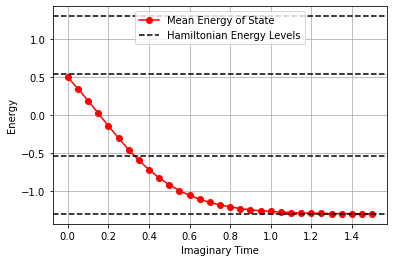

In [9]:
p1, = plt.plot(np.arange(0,N+1)*db, E, 'ro-')
w,v = get_spectrum(hm_list,nbits)
for energy_level in w:
    p2= plt.axhline(y=energy_level, color='k', linestyle='--')
    
plt.legend((p1,p2), ('Mean Energy of State', 'Hamiltonian Energy Levels'), loc='upper center')

plt.xlabel('Imaginary Time')
plt.ylabel('Energy')
plt.grid()

plt.savefig('ideal-qite')

plt.show()

In [10]:
for psi in states:
    print(psi.data)
print(len(states))

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
[ 0.99940517+0.j  0.        +0.j -0.03448617+0.j  0.        +0.j]
[ 0.99552935+0.j  0.        +0.j -0.0944527 +0.j  0.        +0.j]
[ 0.9878262 +0.j  0.        +0.j -0.15556158+0.j  0.        +0.j]
[ 0.97625054+0.j  0.        +0.j -0.21664462+0.j  0.        +0.j]
[ 0.96100919+0.j  0.        +0.j -0.27651644+0.j  0.        +0.j]
[ 0.94254361+0.j  0.        +0.j -0.33408313+0.j  0.        +0.j]
[ 0.92147636+0.j  0.        +0.j -0.38843445+0.j  0.        +0.j]
[ 0.89853481+0.j  0.        +0.j -0.43890225+0.j  0.        +0.j]
[ 0.87447039+0.j  0.        +0.j -0.48507891+0.j  0.        +0.j]
[ 0.84998913+0.j  0.        +0.j -0.52680022+0.j  0.        +0.j]
[ 0.82570337+0.j  0.        +0.j -0.56410455+0.j  0.        +0.j]
[ 0.80210637+0.j  0.        +0.j -0.59718119+0.j  0.        +0.j]
[ 0.77956679+0.j  0.        +0.j -0.6263191 +0.j  0.        +0.j]
[ 0.75833706+0.j  0.        +0.j -0.65186264+0.j  0.        +0.j]
[ 0.73856961+0.j  0.        +0.j -0.67417723+0

In [13]:
def pauli_int_to_char(pstring):
    pstr = ''
    for p in pstring:
        if p==0:
            pstr += 'I'
        else:
            pstr += chr(ord('X')+p-1)
    return pstr

def print_hamiltonian(hm_list):
    term_num = 1
    for hm in hm_list:
        for j in range(len(hm[0])):
            pstring = pauli_int_to_char(int_to_base(hm[0][j],4,len(hm[2])))
            print('Term {}:'.format(term_num))
            print('({:.2f}) {} acting on qubits {}'.format(hm[1][j], pstring, hm[2]))

In [14]:
print_hamiltonian(hm_list)

Term 1:
(0.71) ZX acting on qubits [0, 1]
Term 1:
(0.50) X acting on qubits [1]
Term 1:
(0.50) Z acting on qubits [1]


## Use alist to restore the state vector at each imaginary time step

In [93]:
x = np.load('./ideal-qite.npy',allow_pickle=True)
db = x[0]
delta = x[1]
N = x[2]
nbits = x[3]
hm_list = x[4]
alist = x[5]

def get_psis(hm_list, alist, nbits):
    nterms = len(hm_list)
    N = len(alist)//nterms
        
    states = []
    states.append(Statevector.from_label('0'*nbits))
    
    for i in range(1,N+1):
        qc = QuantumCircuit(nbits)
        propogate(qc, alist[0:i*nterms])
        states.append(states[0].evolve(qc))
    return states

psis = get_psis(hm_list, alist, nbits)

w,v = get_spectrum(hm_list,nbits)

energy_state_probs = np.zeros([len(w), N+1], dtype=float)

mean_energies = np.zeros(N+1,dtype=float)

hmat = get_h_matrix(hm_list, nbits)

for i in range(N+1):
    for j in range(len(w)):
        energy_state_probs[j][i] = np.abs( np.vdot(v[:,j], psis[i].data) )**2
    mean_energies[i] = np.real(np.conj(psis[i].data).T @ hmat @ psis[i].data)

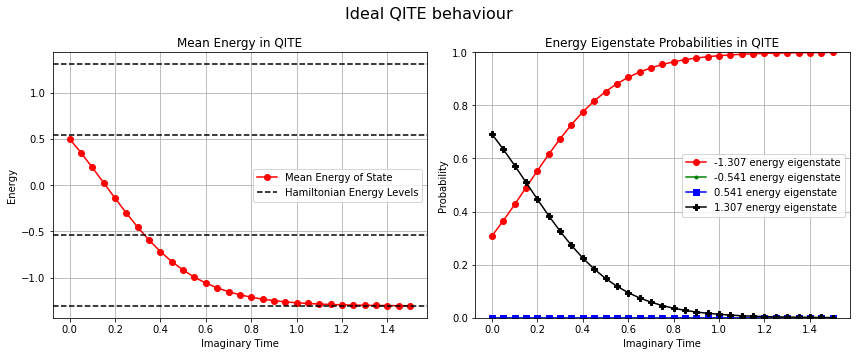

In [100]:
fig, axs = plt.subplots(1,2, figsize = (12,5))

w = np.real(w)
w_sort_i = sorted(range(len(w)), key=lambda k: w[k])

fig.suptitle('Ideal QITE behaviour', fontsize=16)
plt.subplots_adjust(top=0.85)

p1, = axs[0].plot(np.arange(0,N+1)*db, mean_energies, 'ro-')
for ei in w:
    p2 = axs[0].axhline(y=ei, color='k', linestyle='--')
axs[0].set_title('Mean Energy in QITE')
axs[0].set_ylabel('Energy')
axs[0].set_xlabel('Imaginary Time')
axs[0].grid()
axs[0].legend((p1,p2), ('Mean Energy of State', 'Hamiltonian Energy Levels'), loc='best')

axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[0]], 'ro-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[0]]))
axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[1]], 'g.-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[1]]))
axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[2]], 'bs-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[2]]))
axs[1].plot(np.arange(0,N+1)*db, energy_state_probs[w_sort_i[3]], 'kP-', label='{:0.3f} energy eigenstate'.format(w[w_sort_i[3]]))

axs[1].set_title('Energy Eigenstate Probabilities in QITE')
axs[1].set_ylim([0,1])
axs[1].set_ylabel('Probability')
axs[1].set_xlabel('Imaginary Time')

axs[1].grid()
axs[1].legend(loc='best')

fig.tight_layout()

plt.savefig('./figs/probabilities/ideal-qite')

plt.show()

In [5]:
print('{:0.1f}'.format(0.0))

0.0
